<a href="https://colab.research.google.com/github/AnanyaGupta-Rootingit/MUTUAL-FUND-SCREENER/blob/main/MUTUAL_FUND_SCREENER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================
# General File Upload + Preview
# ==============================
from google.colab import files
import pandas as pd
import os

# Step 1: Upload files
print("📂 Please upload your file(s):")
uploaded = files.upload()

# Step 2: Save uploaded files to Colab filesystem
for filename in uploaded.keys():
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    print(f"✅ Saved file: {filename}")

# Step 3: Optional - Read CSV or Excel files into pandas
for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        print(f"\n📄 Contents of {filename}:")
        print(df.head())
    elif filename.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(filename)
        print(f"\n📄 Contents of {filename}:")
        print(df.head())
    else:
        print(f"\n⚠️ {filename} is not a CSV or Excel file. Skipping preview.")


# ==============================
# Phase 1 – Setup & Data Collection (Hybrid: CSV + API)
# ==============================
!pip install mftool deprecated

from mftool import Mftool  # Corrected import
from datetime import datetime

# Step 0: Upload local datasets (if not already uploaded)
metadata_file = "mutual_fund_metadata.csv"
nav_history_file = "mutual_fund_nav_history.csv"

if not os.path.exists(metadata_file) or not os.path.exists(nav_history_file):
    print(f"📂 Please upload '{metadata_file}' and '{nav_history_file}'")
    uploaded = files.upload()
    if not os.path.exists(metadata_file) or not os.path.exists(nav_history_file):
        print("❌ File upload failed or files not found. Please upload manually.")
        exit()
else:
    print("✅ Files already exist. Skipping upload.")

# Load datasets
metadata = pd.read_csv(metadata_file)
nav_history = pd.read_csv(nav_history_file)

# Convert 'Date' column to datetime
nav_history["Date"] = pd.to_datetime(nav_history["Date"], errors="coerce")

print("Local Metadata Sample:")
print(metadata.head())
print("\nLocal NAV History Sample:")
print(nav_history.head())

# Step 1: API Setup & Refresh NAV History
mf_tool = Mftool()
refreshed_entries = []
print("\n🔄 Refreshing NAV history via API...")

for scheme_code in metadata["Scheme_Code"].astype(str).unique():
    try:
        latest_nav_data = mf_tool.get_latest_nav(scheme_code)

        if latest_nav_data and 'data' in latest_nav_data and latest_nav_data['data']:
            latest_nav_entry = latest_nav_data['data'][0]
            latest_date = pd.to_datetime(latest_nav_entry['date'], errors="coerce")
            max_local_date = nav_history.loc[nav_history["Scheme_Code"] == scheme_code, "Date"].max()

            if pd.isna(max_local_date) or latest_date > max_local_date:
                refreshed_entries.append({
                    "Date": latest_date,
                    "Scheme_Code": scheme_code,
                    "NAV": float(latest_nav_entry["nav"])
                })
                print(f"✅ Found new NAV for scheme {scheme_code}")

    except Exception as e:
        print(f"⚠️ Error fetching latest NAV for scheme code {scheme_code}: {e}")

# Append new entries to history (if any)
if refreshed_entries:
    updated_df = pd.DataFrame(refreshed_entries)
    nav_history = pd.concat([nav_history, updated_df], ignore_index=True)
    print("\n✅ Successfully appended new NAV data.")
else:
    print("\nℹ️ No new NAV data found. Your dataset is up-to-date.")

# Step 2: Save Refreshed Dataset
nav_history = nav_history.drop_duplicates(subset=["Date", "Scheme_Code"])
nav_history = nav_history.sort_values(by=["Scheme_Code", "Date"])

output_file = "mutual_fund_nav_history_refreshed.csv"
nav_history.to_csv(output_file, index=False)

print("\n📦 Updated NAV history saved as:", output_file)
print("Latest records:\n", nav_history.tail())

# Allow download of updated file
files.download(output_file)


📂 Please upload your file(s):


Saving mutual_fund_metadata.csv to mutual_fund_metadata (2).csv
Saving mutual_fund_nav_history.csv to mutual_fund_nav_history (2).csv
✅ Saved file: mutual_fund_metadata (2).csv
✅ Saved file: mutual_fund_nav_history (2).csv

📄 Contents of mutual_fund_metadata (2).csv:
   Scheme_Code                   Scheme_Name                  AMC Category  \
0       100001              HDFC Equity Fund              HDFC MF   Equity   
1       100002             SBI Bluechip Fund               SBI MF   Equity   
2       100003  ICICI Pru Balanced Advantage  ICICI Prudential MF   Hybrid   

   Expense_Ratio Benchmark  
0            1.2  NIFTY 50  
1            1.1    SENSEX  
2            0.9  NIFTY 50  

📄 Contents of mutual_fund_nav_history (2).csv:
         Date  Scheme_Code    NAV
0  2023-01-01       100001  350.0
1  2023-01-02       100001  351.0
2  2023-01-03       100001  352.0
3  2023-01-04       100001  353.0
4  2023-01-05       100001  354.0
✅ Files already exist. Skipping upload.
Local Metad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# Load mutual fund NAV history
# ---------------------------
from google.colab import files

print("📂 Please upload 'mutual_fund_nav_history.csv'")
uploaded = files.upload()

nav_history = pd.read_csv("mutual_fund_nav_history.csv")

# Ensure correct datatypes
nav_history['Date'] = pd.to_datetime(nav_history['Date'])
nav_history = nav_history.sort_values(['Scheme_Code', 'Date'])

# ---------------------------
# Step 1: Daily Returns
# ---------------------------
nav_history['Daily_Return'] = nav_history.groupby('Scheme_Code')['NAV'].pct_change()

# ---------------------------
# Step 2: CAGR (Annualized Return)
# ---------------------------
def calculate_cagr(df):
    start_value = df['NAV'].iloc[0]
    end_value = df['NAV'].iloc[-1]
    n_years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.0
    return (end_value / start_value) ** (1/n_years) - 1 if n_years > 0 else np.nan

cagr = nav_history.groupby('Scheme_Code').apply(calculate_cagr)

# ---------------------------
# Step 3: Volatility (Std Dev of daily returns)
# ---------------------------
volatility = nav_history.groupby('Scheme_Code')['Daily_Return'].std() * np.sqrt(252)

# ---------------------------
# Step 4: Sharpe Ratio
# ---------------------------
risk_free_rate = 0.06  # assume 6% annual
sharpe_ratio = (cagr - risk_free_rate) / volatility

# ---------------------------
# Step 5: Sortino Ratio
# ---------------------------
def downside_deviation(x):
    downside = x[x < 0]
    if len(downside) == 0:
        return np.nan  # no negative returns
    return downside.std() * np.sqrt(252)

downside_vol = nav_history.groupby('Scheme_Code')['Daily_Return'].apply(downside_deviation)

# Calculate Sortino
raw_sortino = (cagr - risk_free_rate) / downside_vol.replace(0, np.nan)

# Replace NaN with descriptive label
sortino_ratio = raw_sortino.where(~raw_sortino.isna(), other="No downside risk")
# ---------------------------
# Step 6: Beta & Alpha (vs Benchmark)
# ---------------------------
# ---- If no benchmark file, create dummy benchmark (random walk) ----
try:
    benchmark = pd.read_csv("benchmark.csv")
    benchmark['Date'] = pd.to_datetime(benchmark['Date'])
    benchmark = benchmark.sort_values('Date')
    benchmark['Benchmark_Return'] = benchmark['NAV'].pct_change()
except:
    print("⚠️ No benchmark uploaded, generating dummy benchmark series...")
    # Generate synthetic benchmark (similar length as NAV history)
    unique_dates = nav_history['Date'].unique()
    np.random.seed(42)
    benchmark = pd.DataFrame({
        'Date': unique_dates,
        'NAV': np.cumprod(1 + np.random.normal(0.0005, 0.01, len(unique_dates))) * 100
    })
    benchmark['Benchmark_Return'] = benchmark['NAV'].pct_change()

# Merge benchmark with NAV history
merged = nav_history.merge(benchmark[['Date','Benchmark_Return']], on="Date", how="inner")

betas, alphas = {}, {}
for scheme, df in merged.groupby("Scheme_Code"):
    cov_matrix = np.cov(df['Daily_Return'].dropna(), df['Benchmark_Return'].dropna())
    beta = cov_matrix[0,1] / cov_matrix[1,1]
    alpha = (cagr[scheme] - risk_free_rate) - beta * (benchmark['Benchmark_Return'].mean() * 252)
    betas[scheme] = beta
    alphas[scheme] = alpha

# ---------------------------
# Final Summary Table
# ---------------------------
summary = pd.DataFrame({
    "CAGR": cagr,
    "Volatility": volatility,
    "Sharpe_Ratio": sharpe_ratio,
    "Sortino_Ratio": sortino_ratio,
    "Beta": pd.Series(betas),
    "Alpha": pd.Series(alphas)
})

summary = summary.round(4)
print("\n📊 Fund Performance Metrics:")
display(summary)


📂 Please upload 'mutual_fund_nav_history.csv'


Saving mutual_fund_nav_history.csv to mutual_fund_nav_history (1).csv
⚠️ No benchmark uploaded, generating dummy benchmark series...

📊 Fund Performance Metrics:


/tmp/ipython-input-1207307397.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cagr = nav_history.groupby('Scheme_Code').apply(calculate_cagr)


,CAGR,Volatility,Sharpe_Ratio,Sortino_Ratio,Beta,Alpha
100001,1.8002,0.0003,5015.4923,No downside risk,0.0001,1.7401
100002,3.4505,0.0007,4641.9948,No downside risk,0.0001,3.3903
100003,3.1968,0.0007,4654.0765,No downside risk,0.0001,3.1367


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

# Step 1: Upload datasets again
uploaded = files.upload()

metadata = pd.read_csv("mutual_fund_metadata.csv")
nav_history = pd.read_csv("mutual_fund_nav_history.csv")

# Step 2: Data Cleaning
metadata.columns = metadata.columns.str.strip().str.lower().str.replace(" ", "_")
nav_history.columns = nav_history.columns.str.strip().str.lower().str.replace(" ", "_")

# Convert date and sort NAV history
nav_history["date"] = pd.to_datetime(nav_history["date"])
nav_history = nav_history.sort_values(["scheme_code", "date"])

# Step 3: Compute CAGR for 1Y, 3Y, 5Y
def calculate_cagr(df, years):
    df = df.copy()
    try:
        start_date = df["date"].max() - pd.DateOffset(years=years)
        df_period = df[df["date"] >= start_date]
        if len(df_period) > 1:
            start_nav = df_period.iloc[0]["nav"]
            end_nav = df_period.iloc[-1]["nav"]
            cagr = ((end_nav / start_nav) ** (1/years)) - 1
            return cagr
    except:
        return np.nan
    return np.nan

cagr_data = []
for scheme, group in nav_history.groupby("scheme_code"):
    cagr_1y = calculate_cagr(group, 1)
    cagr_3y = calculate_cagr(group, 3)
    cagr_5y = calculate_cagr(group, 5)
    cagr_data.append([scheme, cagr_1y, cagr_3y, cagr_5y])

cagr_df = pd.DataFrame(cagr_data, columns=["scheme_code", "cagr_1y", "cagr_3y", "cagr_5y"])

# Merge CAGR with metadata
funds = metadata.merge(cagr_df, on="scheme_code", how="left")

# Step 4: Filtering Functions
def filter_by_amc(fund_house):
    return funds[funds["amc"].str.contains(fund_house, case=False, na=False)]

def filter_by_category(category):
    return funds[funds["category"].str.contains(category, case=False, na=False)]

def filter_by_expense_ratio(max_ratio):
    return funds[funds["expense_ratio"] <= max_ratio]

def filter_by_min_investment(max_investment):
    return funds[funds["minimum_investment"] <= max_investment]

# Step 5: Sorting Functions
def top_performing(period="cagr_3y", top_n=10):
    return funds.sort_values(by=period, ascending=False).head(top_n)

def lowest_expense_ratio(top_n=10):
    return funds.sort_values(by="expense_ratio", ascending=True).head(top_n)

def best_risk_adjusted(top_n=10):
    if "sharpe_ratio" not in funds.columns:
        print("Sharpe ratio not available in dataset.")
        return None
    return funds.sort_values(by="sharpe_ratio", ascending=False).head(top_n)

# ✅ Example Usage
print("🔹 Top Performing (3Y CAGR)")
print(top_performing("cagr_3y", 5)[["scheme_name", "cagr_3y", "amc"]])

print("\n🔹 Lowest Expense Ratio")
print(lowest_expense_ratio(5)[["scheme_name", "expense_ratio", "amc"]])

print("\n🔹 Filter by AMC: SBI")
print(filter_by_amc("SBI")[["scheme_name", "category", "amc"]].head(5))

print("\n🔹 Filter by Category: Equity")
print(filter_by_category("Equity")[["scheme_name", "category", "amc"]].head(5))

Saving mutual_fund_metadata.csv to mutual_fund_metadata (1).csv
Saving mutual_fund_nav_history.csv to mutual_fund_nav_history (1).csv
🔹 Top Performing (3Y CAGR)
                    scheme_name   cagr_3y                  amc
1             SBI Bluechip Fund  0.012347               SBI MF
2  ICICI Pru Balanced Advantage  0.011859  ICICI Prudential MF
0              HDFC Equity Fund  0.008499              HDFC MF

🔹 Lowest Expense Ratio
                    scheme_name  expense_ratio                  amc
2  ICICI Pru Balanced Advantage            0.9  ICICI Prudential MF
1             SBI Bluechip Fund            1.1               SBI MF
0              HDFC Equity Fund            1.2              HDFC MF

🔹 Filter by AMC: SBI
         scheme_name category     amc
1  SBI Bluechip Fund   Equity  SBI MF

🔹 Filter by Category: Equity
         scheme_name category      amc
0   HDFC Equity Fund   Equity  HDFC MF
1  SBI Bluechip Fund   Equity   SBI MF


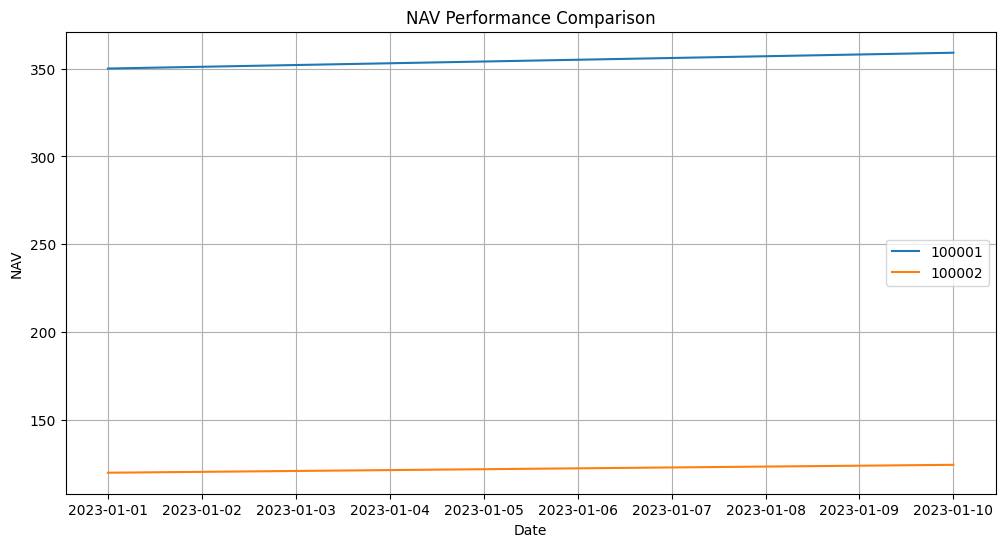

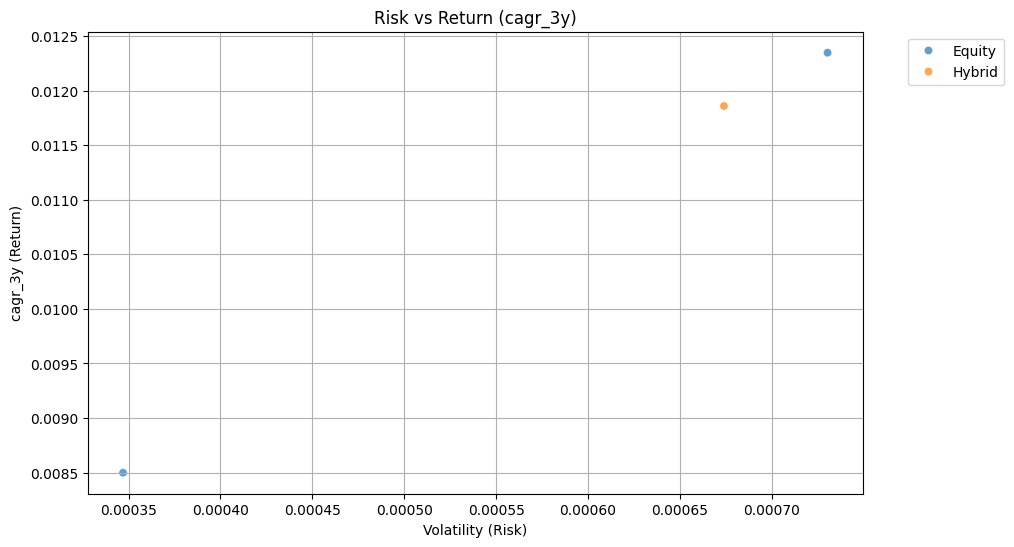

⚠️ Cannot generate radar plot: No data available for selected metrics and schemes.
⚠️ No data available for selected schemes.


In [ ]:
# ==============================
# Phase 4 – Visualization (Debugged & Enhanced)
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler # Import for normalization

# Make sure matplotlib shows plots in Colab
%matplotlib inline

# --- 📊 NAV Performance Comparison ---
def plot_nav_comparison(scheme_codes, nav_history):
    plt.figure(figsize=(12,6))
    for scheme in scheme_codes:
        scheme_data = nav_history[nav_history["scheme_code"].astype(str) == str(scheme)]
        if not scheme_data.empty:
            plt.plot(scheme_data["date"], scheme_data["nav"], label=str(scheme))
        else:
            print(f"⚠️ No NAV data found for {scheme}")
    plt.title("NAV Performance Comparison")
    plt.xlabel("Date")
    plt.ylabel("NAV")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 📈 Risk vs Return Scatter ---
def plot_risk_return(funds, nav_history, period="cagr_3y"):
    risk_data = []
    for scheme, group in nav_history.groupby("scheme_code"):
        group = group.sort_values("date")
        group["Daily_Return"] = group["nav"].pct_change()
        if group["Daily_Return"].notna().sum() > 0:
            volatility = group["Daily_Return"].std() * np.sqrt(252)  # annualized
            risk_data.append([scheme, volatility])
    risk_df = pd.DataFrame(risk_data, columns=["scheme_code", "Volatility"])

    merged = funds.merge(risk_df, on="scheme_code", how="left")

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=merged, x="Volatility", y=period, hue="category", alpha=0.7)
    plt.title(f"Risk vs Return ({period})")
    plt.xlabel("Volatility (Risk)")
    plt.ylabel(f"{period} (Return)")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.grid(True)
    plt.show()

# --- 🕸️ Spider/Radar Plot ---
def plot_radar(funds, scheme_codes):
    selected = funds[funds["scheme_code"].isin(scheme_codes)].copy() # Create a copy to avoid SettingWithCopyWarning
    metrics = ["cagr_3y", "cagr_5y", "expense_ratio"]

    # Normalize metrics
    scaler = MinMaxScaler()
    # Exclude rows with NaN in metrics before scaling
    selected_for_scaling = selected.dropna(subset=metrics)

    if not selected_for_scaling.empty:
        selected.loc[selected_for_scaling.index, metrics] = scaler.fit_transform(selected_for_scaling[metrics])
    else:
        print("⚠️ Cannot generate radar plot: No data available for selected metrics and schemes.")
        return

    categories = metrics + [metrics[0]]  # loop back

    fig = go.Figure()

    for _, row in selected.iterrows():
        # Use normalized values, handle potential NaNs after merge
        values = [row[m] if pd.notnull(row[m]) else 0 for m in metrics]
        values += values[:1]
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories,
            fill="toself",
            name=row["scheme_name"]
        ))

    fig.update_layout(
      polar=dict(radialaxis=dict(visible=True, range=[0, 1])), # Set range for normalized data
      showlegend=True,
      title="Fund Comparison Radar Plot (Normalized Metrics)"
    )
    fig.show()


# --- 📊 Bar Chart for CAGR Comparison ---
def plot_cagr_bar_chart(funds, scheme_codes, period="cagr_3y"):
    selected = funds[funds["scheme_code"].isin(scheme_codes)].copy()
    if selected.empty:
        print("⚠️ No data available for selected schemes.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x="scheme_name", y=period, data=selected)
    plt.title(f"CAGR Comparison ({period})")
    plt.xlabel("Scheme Name")
    plt.ylabel(period)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# --- 🥧 Portfolio Pie Chart (if holdings available) ---
def plot_portfolio_pie(holdings_df, scheme_code):
    scheme_data = holdings_df[holdings_df["scheme_code"] == scheme_code]
    if scheme_data.empty:
        print("⚠️ Holdings data not available for this scheme.")
        return

    plt.figure(figsize=(8,8))
    plt.pie(scheme_data["Weight"], labels=scheme_data["Sector"], autopct="%1.1f%%", startangle=140)
    plt.title(f"Portfolio Exposure - {scheme_code}")
    plt.show()

# =====================
# ✅ Example Usage
# =====================
# Make sure your dataset columns are:
# metadata/funds → ["scheme_code", "scheme_name", "category", "cagr_3y", "cagr_5y", "expense_ratio"]
# nav_history    → ["scheme_code", "date", "nav"]

plot_nav_comparison(["100001", "100002"], nav_history)
plot_risk_return(funds, nav_history, "cagr_3y")
plot_radar(funds, ["100001", "100002", "100003"])
plot_cagr_bar_chart(funds, ["100001", "100002", "100003"], "cagr_3y")


# If you have holdings data:
# holdings_df = pd.read_csv("mutual_fund_holdings.csv")
# plot_portfolio_pie(holdings_df, "118550")

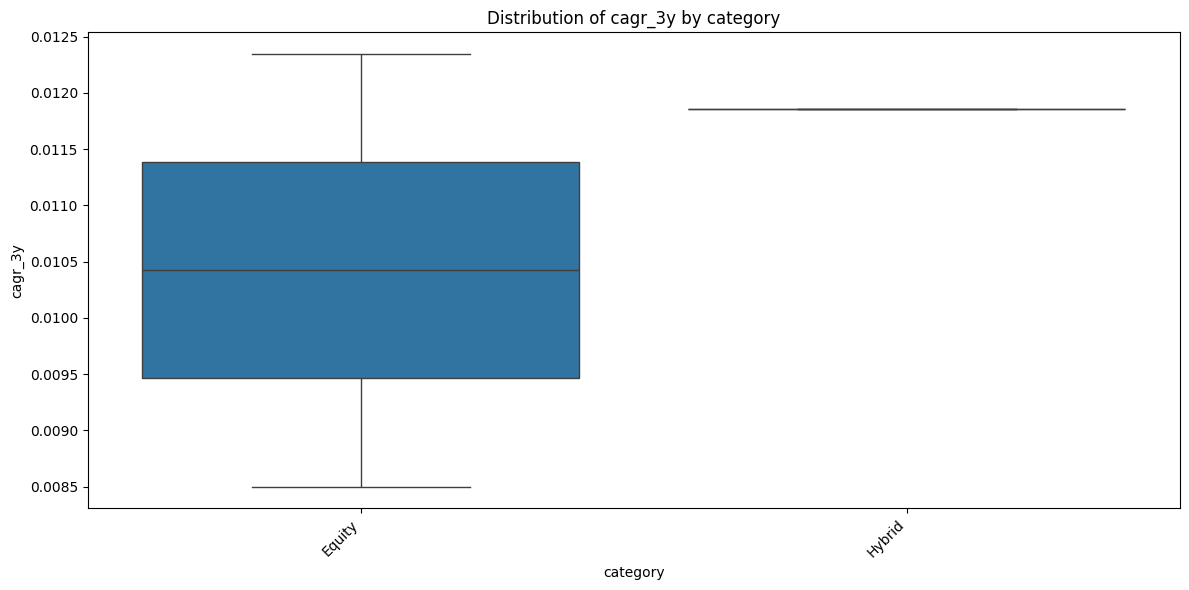

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 📊 Box Plot of Metrics by Category ---
def plot_boxplot_by_category(funds, metric="cagr_3y", category="category"):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=category, y=metric, data=funds)
    plt.title(f"Distribution of {metric} by {category}")
    plt.xlabel(category)
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ✅ Example Usage
plot_boxplot_by_category(funds, metric="cagr_3y", category="category")

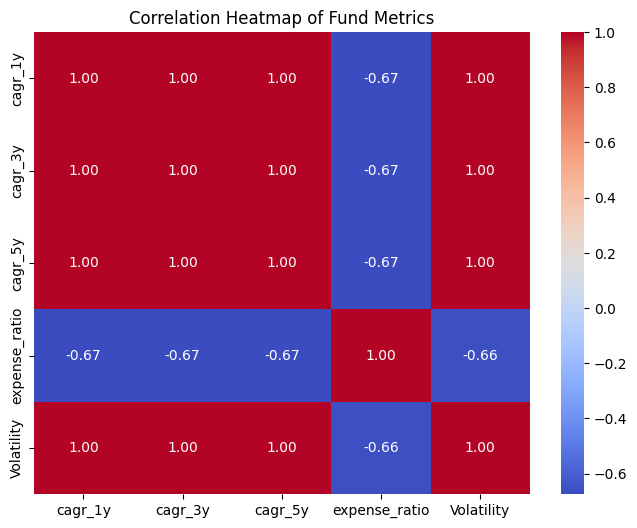

In [ ]:
# --- 📊 Heatmap of Correlations ---
def plot_correlation_heatmap(funds):
    metrics = ["cagr_1y", "cagr_3y", "cagr_5y", "expense_ratio", "Volatility"] # Add Volatility if calculated and merged

    # Ensure 'funds' has 'Volatility' if 'plot_risk_return' was run
    if "Volatility" not in funds.columns:
         risk_data = []
         for scheme, group in nav_history.groupby("scheme_code"):
            group = group.sort_values("date")
            group["Daily_Return"] = group["nav"].pct_change()
            if group["Daily_Return"].notna().sum() > 0:
                volatility = group["Daily_Return"].std() * np.sqrt(252)  # annualized
                risk_data.append([scheme, volatility])
         risk_df = pd.DataFrame(risk_data, columns=["scheme_code", "Volatility"])
         funds = funds.merge(risk_df, on="scheme_code", how="left")


    correlation_matrix = funds[metrics].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Fund Metrics")
    plt.show()

# ✅ Example Usage
plot_correlation_heatmap(funds)

In [ ]:
# Phase 5 – Advanced Features: Smart Score, Recommendation Engine, Overlap Analysis
# Colab-ready. Upload: mutual_fund_metadata.csv, mutual_fund_nav_history.csv, (optional) mutual_fund_holdings.csv
# Requires: pip install ipywidgets (for sliders, but Colab has basic support)

import pandas as pd
import numpy as np
from google.colab import files
from datetime import datetime
import io
import math
import os # Import os module

# Optional: interactive sliders in Colab
try:
    from ipywidgets import interact, FloatSlider, fixed
    interactive_available = True
except Exception:
    interactive_available = False

# ---------------------------
# Upload datasets
# ---------------------------
# Load required files robustly (normalize names)
def load_uploaded_csv(filename_keys):
    # Check if file exists in /content from previous uploads
    for key in filename_keys:
        if os.path.exists(key):
            print(f"✅ Found existing file: {key}")
            return pd.read_csv(key)

    # If not found locally, try to load from files.upload() dict
    if 'uploaded' in globals() and uploaded:
        for key in filename_keys:
            if key in uploaded:
                 print(f"✅ Loading from uploaded files: {key}")
                 return pd.read_csv(io.BytesIO(uploaded[key]))
        # try case-insensitive from uploaded dict
        for key in uploaded:
            for fk in filename_keys:
                if fk.lower() in key.lower():
                     print(f"✅ Loading from uploaded files (case-insensitive): {key}")
                     return pd.read_csv(io.BytesIO(uploaded[key]))
    return None

# Try loading first, if not found, prompt upload
metadata = load_uploaded_csv(["mutual_fund_metadata.csv","metadata.csv","funds_metadata.csv"])
nav_history = load_uploaded_csv(["mutual_fund_nav_history.csv","nav_history.csv","nav.csv"])
holdings = load_uploaded_csv(["mutual_fund_holdings.csv","holdings.csv"])  # optional

if metadata is None or nav_history is None:
    print("📂 Required files not found locally. Please upload:")
    print("- mutual_fund_metadata.csv (or similar)")
    print("- mutual_fund_nav_history.csv (or similar)")
    if holdings is None:
        print("- mutual_fund_holdings.csv (optional)")

    uploaded = files.upload() # Prompt upload if files not found

    # Try loading again from the new upload
    metadata = load_uploaded_csv(["mutual_fund_metadata.csv","metadata.csv","funds_metadata.csv"])
    nav_history = load_uploaded_csv(["mutual_fund_nav_history.csv","nav_history.csv","nav.csv"])
    holdings = load_uploaded_csv(["mutual_fund_holdings.csv","holdings.csv"])  # optional

    if metadata is None or nav_history is None:
         raise FileNotFoundError("Required metadata or nav_history CSVs still not found after upload attempt.")


# ---------------------------
# Normalize column names
# ---------------------------
def norm_cols(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

metadata = norm_cols(metadata)
nav_history = norm_cols(nav_history)
if holdings is not None:
    holdings = norm_cols(holdings)

# Expected column mapping helper
def map_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# map critical columns
meta_code_col = map_col(metadata, ["scheme_code","schemeid","code","id"])
meta_name_col = map_col(metadata, ["scheme_name","name","fund_name"])
meta_amc_col = map_col(metadata, ["amc","amc_name","fund_house"])
meta_cat_col = map_col(metadata, ["category","fund_category","type"])
meta_exp_col = map_col(metadata, ["expense_ratio","ter","expense"])
meta_mininv_col = map_col(metadata, ["minimum_investment","min_investment","min_inv"])

nav_code_col = map_col(nav_history, ["scheme_code","schemeid","code","id"])
nav_date_col = map_col(nav_history, ["date","nav_date"])
nav_nav_col = map_col(nav_history, ["nav","nav_value","navs"])

if not nav_code_col or not nav_date_col or not nav_nav_col:
    raise ValueError("nav_history must have columns like 'scheme_code','date','nav' (case-insensitive).")

# standardize names in dataframes
metadata = metadata.rename(columns={c: "scheme_code" for c in [meta_code_col] if c})
if meta_name_col: metadata = metadata.rename(columns={meta_name_col: "scheme_name"})
if meta_amc_col: metadata = metadata.rename(columns={meta_amc_col: "amc"})
if meta_cat_col: metadata = metadata.rename(columns={meta_cat_col: "category"})
if meta_exp_col: metadata = metadata.rename(columns={meta_exp_col: "expense_ratio"})
if meta_mininv_col: metadata = metadata.rename(columns={meta_mininv_col: "minimum_investment"})

nav_history = nav_history.rename(columns={nav_code_col: "scheme_code", nav_date_col: "date", nav_nav_col: "nav"})

if holdings is not None:
    # try to standardize holdings columns: scheme_code, stock/sector, weight
    holdings_code = map_col(holdings, ["scheme_code","schemeid","code","fund_code"])
    holdings_asset = map_col(holdings, ["stock","holding","security","name","ticker","sector"])
    holdings_weight = map_col(holdings, ["weight","percentage","pct","weight_pct","holding_percent"])
    if holdings_code:
        holdings = holdings.rename(columns={holdings_code: "scheme_code"})
    if holdings_asset:
        holdings = holdings.rename(columns={holdings_asset: "asset"})
    if holdings_weight:
        holdings = holdings.rename(columns={holdings_weight: "weight"})

# Ensure types
metadata["scheme_code"] = metadata["scheme_code"].astype(str)
nav_history["scheme_code"] = nav_history["scheme_code"].astype(str)
nav_history["date"] = pd.to_datetime(nav_history["date"], errors="coerce")
nav_history["nav"] = pd.to_numeric(nav_history["nav"], errors="coerce")

if "expense_ratio" in metadata.columns:
    metadata["expense_ratio"] = pd.to_numeric(metadata["expense_ratio"], errors="coerce")

# ---------------------------
# Helper metrics functions
# ---------------------------
def compute_scheme_metrics(nav_df, ref_date=None):
    """
    For each scheme_code compute:
    - last_date, last_nav
    - CAGR 1/3/5 if available (else NaN)
    - annualized volatility, Sharpe, Sortino from last ~1 year if possible (fallback to all history)
    Returns DataFrame indexed by scheme_code with columns.
    """
    rf = 0.06  # annual risk free
    results = []
    if ref_date is None:
        ref_date = nav_df["date"].max()
    scheme_codes = nav_df["scheme_code"].unique()
    for code in scheme_codes:
        df = nav_df[nav_df["scheme_code"] == code].sort_values("date").dropna(subset=["nav"])
        if df.empty:
            continue
        last_row = df.iloc[-1]
        last_date = last_row["date"]
        last_nav = float(last_row["nav"])

        def nav_on_or_before(years):
            target = last_date - pd.DateOffset(years=years)
            tmp = df[df["date"] <= target]
            if tmp.empty:
                return None
            return float(tmp.iloc[-1]["nav"])

        def cagr(start_nav, end_nav, years):
            if start_nav is None or start_nav <= 0 or end_nav <= 0:
                return np.nan
            try:
                return (end_nav / start_nav) ** (1.0/years) - 1.0
            except:
                return np.nan

        nav1 = nav_on_or_before(1)
        nav3 = nav_on_or_before(3)
        nav5 = nav_on_or_before(5)

        cagr1 = cagr(nav1, last_nav, 1) if nav1 is not None else np.nan
        cagr3 = cagr(nav3, last_nav, 3) if nav3 is not None else np.nan
        cagr5 = cagr(nav5, last_nav, 5) if nav5 is not None else np.nan

        # daily returns
        df = df.copy()
        df["daily_ret"] = df["nav"].pct_change()
        last_1y_cutoff = last_date - pd.DateOffset(days=365)
        rets_1y = df[df["date"] >= last_1y_cutoff]["daily_ret"].dropna()
        if len(rets_1y) < 30:
            rets_1y = df["daily_ret"].dropna()  # fallback

        if len(rets_1y) >= 2:
            ann_vol = rets_1y.std(ddof=1) * np.sqrt(252)
            # geometric annualized return
            compounded = (1 + rets_1y).prod() if len(rets_1y)>0 else np.nan
            ann_ret = compounded ** (252.0/len(rets_1y)) - 1.0 if not pd.isna(compounded) and len(rets_1y)>0 else np.nan
            # sharpe
            sharpe = (ann_ret - rf) / ann_vol if (not pd.isna(ann_ret) and not pd.isna(ann_vol) and ann_vol>0) else np.nan
            # sortino
            neg = rets_1y[rets_1y < 0]
            if len(neg) > 0:
                downside = neg.std(ddof=1) * np.sqrt(252)
                sortino = (ann_ret - rf) / downside if downside > 0 else np.nan
            else:
                sortino = np.nan
        else:
            ann_vol = np.nan
            sharpe = np.nan
            sortino = np.nan
            ann_ret = np.nan

        results.append({
            "scheme_code": str(code),
            "last_date": last_date,
            "last_nav": last_nav,
            "cagr_1y": cagr1, "cagr_3y": cagr3, "cagr_5y": cagr5,
            "ann_return": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "sortino": sortino
        })

    return pd.DataFrame(results)

# Compute metrics and merge with metadata
metrics_df = compute_scheme_metrics(nav_history)
funds = metadata.merge(metrics_df, on="scheme_code", how="left")

# For display: basic name/amc/category columns
if "scheme_name" not in funds.columns:
    funds["scheme_name"] = funds["scheme_code"]
if "amc" not in funds.columns:
    funds["amc"] = np.nan
if "category" not in funds.columns:
    funds["category"] = np.nan

# ---------------------------
# Smart Scoring Model
# ---------------------------
from scipy.stats import zscore

def compute_smart_score(df, w_return=0.6, w_risk=0.3, w_cost=0.1, return_horizon="cagr_3y"):
    """
    Score = w_return * (normalized_return) + w_risk * (normalized_risk_adj) - w_cost * (normalized_cost)
    All components z-scored (higher better for returns/sharpe; lower better for expense)
    return_horizon: one of 'cagr_1y','cagr_3y','cagr_5y'
    """
    df = df.copy().reset_index(drop=True)
    # Choose return metric
    if return_horizon not in df.columns:
        raise ValueError("Return horizon not in df: " + return_horizon)

    # fill na with median to allow zscore - safer than dropping everything
    # create working cols
    df["ret_metric"] = pd.to_numeric(df[return_horizon], errors="coerce")
    df["risk_metric"] = pd.to_numeric(df["sharpe"] if "sharpe" in df.columns else df.get("sortino", None), errors="coerce")
    df["cost_metric"] = pd.to_numeric(df.get("expense_ratio", np.nan), errors="coerce")

    # compute zscores (higher is better). For cost, we invert sign because lower cost is better
    for col in ["ret_metric","risk_metric","cost_metric"]:
        if col not in df or df[col].dropna().empty:
            df[col + "_z"] = np.nan
        else:
            # if constant, zscore returns nan; handle by subtracting mean and dividing by std
            arr = df[col].fillna(df[col].median()).values.astype(float)
            if np.nanstd(arr) == 0:
                df[col + "_z"] = 0.0
            else:
                df[col + "_z"] = zscore(arr)

    df["cost_metric_z_inv"] = -1 * df["cost_metric_z"]  # because lower cost should increase score

    # normalize weights
    total = float(w_return + w_risk + w_cost)
    if total == 0:
        raise ValueError("Sum of weights must be > 0")
    w_return_n, w_risk_n, w_cost_n = w_return/total, w_risk/total, w_cost/total

    df["smart_score"] = (w_return_n * df["ret_metric_z"].fillna(0) +
                         w_risk_n * df["risk_metric_z"].fillna(0) +
                         w_cost_n * df["cost_metric_z_inv"].fillna(0))

    # attach helpful columns
    out_cols = ["scheme_code","scheme_name","amc","category","expense_ratio",
                "cagr_1y","cagr_3y","cagr_5y","sharpe","sortino","smart_score"]
    for c in out_cols:
        if c not in df.columns:
            df[c] = np.nan

    return df.sort_values("smart_score", ascending=False).reset_index(drop=True)

# If interactive sliders available, show them
def interactive_scorer(default_return=0.6, default_risk=0.3, default_cost=0.1, horizon="cagr_3y"):
    if not interactive_available:
        print("Interactive widgets not available. Call compute_smart_score(...) directly.")
        return

    def _compute(wr, wk, wc):
        print(f"Computing Smart Score (weights R={wr:.2f}, Risk={wk:.2f}, Cost={wc:.2f}, horizon={horizon})")
        scored = compute_smart_score(funds, w_return=wr, w_risk=wk, w_cost=wc, return_horizon=horizon)
        display(scored[["scheme_code","scheme_name","amc","category","expense_ratio","cagr_3y","sharpe","smart_score"]].head(15))
    interact(_compute,
             wr=FloatSlider(min=0.0, max=1.0, step=0.05, value=default_return, description='w_return'),
             wk=FloatSlider(min=0.0, max=1.0, step=0.05, value=default_risk, description='w_risk'),
             wc=FloatSlider(min=0.0, max=1.0, step=0.05, value=default_cost, description='w_cost'))

# ---------------------------
# Fund Recommendation Engine
# ---------------------------
# Basic mapping from user profile -> categories
mapping_time_risk = {
    # short horizon: prefer debt/liquid/ultrashort or low-volatility hybrids
    ("short","low"): ["Debt","Liquid","Ultra Short Duration","Low Duration","Gilt"],
    ("short","medium"): ["Debt","Hybrid"],
    ("short","high"): ["Hybrid","Arbitrage","Conservative Hybrid"],

    ("medium","low"): ["Hybrid","Conservative Hybrid","Debt"],
    ("medium","medium"): ["Hybrid","Balanced","Large Cap","Index"],
    ("medium","high"): ["Large Cap","Multi Cap","Flexi Cap"],

    ("long","low"): ["Large Cap","Index","Balanced"],
    ("long","medium"): ["Large Cap","Multi Cap","Flexi Cap"],
    ("long","high"): ["Small Cap","Mid Cap","Sectoral","Thematic"]
}

def recommend_funds(time_horizon="medium", risk_appetite="medium", top_n=10,
                    w_return=0.6, w_risk=0.3, w_cost=0.1, return_horizon="cagr_3y"):
    # normalize inputs
    time_horizon = time_horizon.lower()
    risk_appetite = risk_appetite.lower()
    key = (time_horizon, risk_appetite)
    categories = mapping_time_risk.get(key, None)
    if categories is None:
        print("Profile not recognized. Options for time_horizon: short/medium/long; risk_appetite: low/medium/high")
        return None

    scored = compute_smart_score(funds, w_return=w_return, w_risk=w_risk, w_cost=w_cost, return_horizon=return_horizon)
    # match by category (case-insensitive contain)
    mask = scored["category"].fillna("").apply(lambda x: any(cat.lower() in x.lower() for cat in categories))
    selected = scored[mask].copy()
    if selected.empty:
        # fallback: try looser matching: category contains any token of categories
        selected = scored[scored["category"].fillna("").str.lower().isin([c.lower() for c in categories])]
    # final sort by smart_score
    final = selected.sort_values("smart_score", ascending=False).head(top_n)
    return final[["scheme_code","scheme_name","amc","category","expense_ratio","cagr_1y","cagr_3y","cagr_5y","sharpe","sortino","smart_score"]]

# ---------------------------
# Fund Overlap Analysis
# ---------------------------
def holdings_overlap(holdings_df, code_a, code_b, by="asset", top_k=20):
    """
    holdings_df should contain columns: scheme_code, asset (stock/sector), weight (numeric % or fraction)
    Returns overlap percentage = sum(min(w_a_i, w_b_i)) across assets.
    """
    if holdings_df is None:
        raise ValueError("Holdings dataset not provided.")
    h = holdings_df.copy()
    if "scheme_code" not in h.columns or by not in h.columns or "weight" not in h.columns:
        raise ValueError("Holdings file must contain 'scheme_code', '{}', and 'weight' columns.".format(by))

    a = h[h["scheme_code"].astype(str) == str(code_a)].copy()
    b = h[h["scheme_code"].astype(str) == str(code_b)].copy()
    if a.empty or b.empty:
        print("Holdings missing for one/both schemes.")
        return None

    # Normalize weights to fraction if percentages >1
    def normalize_weights(df):
        df = df.copy()
        df["weight"] = pd.to_numeric(df["weight"], errors="coerce").fillna(0.0)
        # if weights sum > 1, maybe they are in percent -> convert
        if df["weight"].sum() > 1.5:
            df["weight"] = df["weight"] / 100.0
        return df

    a = normalize_weights(a)
    b = normalize_weights(b)

    # aggregate by asset
    a_agg = a.groupby(by)["weight"].sum().reset_index()
    b_agg = b.groupby(by)["weight"].sum().reset_index()

    merged = a_agg.merge(b_agg, on=by, how="outer", suffixes=("_a","_b")).fillna(0.0)
    merged["min_w"] = merged[["weight_a","weight_b"]].min(axis=1)

    overlap_fraction = merged["min_w"].sum()  # since weights as fractions
    overlap_pct = overlap_fraction * 100.0

    # classify
    if overlap_pct < 20:
        level = "Low"
    elif overlap_pct < 40:
        level = "Medium"
    else:
        level = "High"

    top_common = merged.sort_values("min_w", ascending=False).head(top_k)[[by,"weight_a","weight_b","min_w"]]
    top_common["weight_a_pct"] = top_common["weight_a"]*100
    top_common["weight_b_pct"] = top_common["weight_b"]*100
    top_common["min_pct"] = top_common["min_w"]*100

    return {
        "scheme_a": code_a,
        "scheme_b": code_b,
        "overlap_pct": overlap_pct,
        "level": level,
        "top_common": top_common
    }

# ---------------------------
# Example usage
# ---------------------------

# 1) Interactive Smart Scorer (if supported)
print("\n▶ Smart Scoring example (non-interactive): top 10 by default weights (0.6,0.3,0.1)")
scored_sample = compute_smart_score(funds, w_return=0.6, w_risk=0.3, w_cost=0.1, return_horizon="cagr_3y")
display_cols = ["scheme_code","scheme_name","amc","category","expense_ratio","cagr_3y","sharpe","sortino","smart_score"]
print(scored_sample[display_cols].head(10))

# 2) Recommendation engine example
print("\n▶ Recommendation example for (time_horizon='medium', risk='medium'):")
rec = recommend_funds(time_horizon="medium", risk_appetite="medium", top_n=7,
                      w_return=0.6, w_risk=0.3, w_cost=0.1, return_horizon="cagr_3y")
if rec is not None:
    display(rec)

# 3) Overlap analysis (only if holdings provided)
if holdings is not None:
    # Example: pick two sample scheme codes
    codes = holdings["scheme_code"].unique()
    if len(codes) >= 2:
        a, b = codes[0], codes[1]
        print(f"\n▶ Overlap analysis between {a} and {b}:")
        overlap_res = holdings_overlap(holdings, a, b, by="asset", top_k=10)
        if overlap_res:
            print(f"Overlap %: {overlap_res['overlap_pct']:.2f}%  — Level: {overlap_res['level']}")
            display(overlap_res["top_common"])
    else:
        print("Holdings file has fewer than 2 schemes; cannot do overlap demo.")
else:
    print("\n(No holdings dataset uploaded — skip overlap analysis.)")

# 4) Save results
scored_sample.to_csv("funds_scored.csv", index=False)
print("\nSaved scored funds to funds_scored.csv. Download from Files panel or re-run with files.download().")

✅ Found existing file: mutual_fund_metadata.csv
✅ Found existing file: mutual_fund_nav_history.csv

▶ Smart Scoring example (non-interactive): top 10 by default weights (0.6,0.3,0.1)
  scheme_code                   scheme_name                  amc category  \
0      100001              HDFC Equity Fund              HDFC MF   Equity   
1      100003  ICICI Pru Balanced Advantage  ICICI Prudential MF   Hybrid   
2      100002             SBI Bluechip Fund               SBI MF   Equity   

   expense_ratio  cagr_3y       sharpe  sortino  smart_score  
0            1.2      NaN  2812.518729      NaN     0.316225  
1            0.9      NaN  2421.345827      NaN    -0.051076  
2            1.1      NaN  2386.776992      NaN    -0.265149  

▶ Recommendation example for (time_horizon='medium', risk='medium'):


,scheme_code,scheme_name,amc,category,expense_ratio,cagr_1y,cagr_3y,cagr_5y,sharpe,sortino,smart_score
1,100003,ICICI Pru Balanced Advantage,ICICI Prudential MF,Hybrid,0.9,NaN,NaN,NaN,2421.345827,NaN,-0.051076



(No holdings dataset uploaded — skip overlap analysis.)

Saved scored funds to funds_scored.csv. Download from Files panel or re-run with files.download().
